In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import joblib

In [2]:
## Self explanatory
save_plots = False

## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = True

## Toggle plot grid
show_grid = False

## Black and white?
black_and_white = True

## Drop event if DTF_FixJPsiLambda failed?
dtf_success = True

## Veto physical background
b0_veto = True

In [3]:
saved_models = {
    ## BALANCE
    ## Higher overtraining. Slightly better performance in test (fractions of percentage)
    'sachiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.010,
        'max_leaf_nodes' : 200,
        'max_iter' : 5000,
        'soft_threshold': 0.7,
        'hard_threshold': 0.9924
    },
    ## Lower ovetraining. Looks better under K-S test. Slightly worse performance in test (fractions of percentage)
    'shamshel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.7,
        'hard_threshold': 0.985
    },
    ## BKGSKEW
    ## From an overtraining standpoint, this is the better one of the bkgskew
    'ramiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.656
    },
    ## This has quite more overtraining, but loses less signal
    'israfel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.015,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.714
    },
    ## Salvatore's HBDT, for performance comparison.
    ## Somewhat similar to israfel, does not match his original HBDT
    'sandalphon': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.01,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.637
    }
}

In [4]:
## Either one of the names in list(saved_models) or 'temp' for custom new model
model_to_use = 'shamshel'

if model_to_use in saved_models:
    daughter_momenta = saved_models[model_to_use]['daughter_momenta']
    dataset_type = saved_models[model_to_use]['dataset_type']
    training_params = {key: saved_models[model_to_use][key] for key in ['learning_rate', 'max_leaf_nodes', 'max_iter']}
    hard_threshold = saved_models[model_to_use]['hard_threshold']
elif model_to_use == 'temp':
    ## Proton and pion momenta
    ## 'VF': use VF momenta
    ## 'DTF': use DTF momenta w/ JPsi m.c.
    ## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
    ## 'NO': don't use any momenta for Lambda daughter particles
    daughter_momenta = 'DTF'

    ## Two options:
    ## 'balance': same number of training events for signal and bkg
    ## 'bkgskew' uses 4 mln events of bkg, 500k of signal
    dataset_type = 'bkgskew'

    training_params = {
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 5000
    }
    
    hard_threshold = 0.9
else:
    raise ValueError

In [5]:
if dataset_type not in ['balance', 'bkgskew']:
    raise ValueError

In [6]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [7]:
if dataset_type == 'balance':
    dataset_suffix = 'BAL'
else:
    dataset_suffix = 'SKEW'

classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
    + '_' + dataset_suffix
)

classifier_dump_filename

'HBDT_DTF_0.003_100_2500_BAL'

In [8]:
## Create plots directory, if missing
repo_directory = str(pathlib.Path.home()) + '/lambda-emdm-measurement/'
state_directory = str(pathlib.Path.home()) + '/classifier-studies/' + '20_HBDT/' + 'saved_states/'

plot_directory = (
    repo_directory + 'plots/'
    + 'angular_distribution_study/'
)

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

In [9]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_mc = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'
input_data = path_to_hd5_files + 'LHCbData_2016-2017-2018_MagUpDown_Dimuon_Ttracks_v2.h5'

# Data prepping
## Import Monte Carlo data

In [10]:
def p_modulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def transverse_p_modulus(px, py):
    return np.sqrt(px**2 + py**2)

In [11]:
df_reco = pd.read_hdf(input_mc, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_mc, key='LHCbMCTruth_Lb')
df_mc = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_mc = df_mc.loc[(df_mc['MC_key'] >= 0) & (df_mc['Rec_key'] >= 0)]

del(df_reco, df_truth)

In [12]:
jpsi_pdg_mass = 3096.900
b0_pdg_mass = 5279.61
b0_veto_threshold = 70

In [13]:
## Missing "combined" invariant masses (for Lambda->p pim and Lambdab->JPsi Lambda)
## These are the AM in the DaVinci config file. Did Salvatore implement them somewhere?

pion_p_cuts = (
    (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) > 2000)
    & (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) < 5e5)
)

proton_p_cuts = (
    (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) > 10000)
    & (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) < 5e5)
)

proton_pt_cuts = transverse_p_modulus(df_mc['p_PX'], df_mc['p_PY']) > 400

lambda_m_cuts = (df_mc['L_M'] > 600) & (df_mc['L_M'] < 1500)
lambda_mm_cuts = df_mc['L_MM'] < 1500
lambda_z_cuts = (df_mc['L_ENDVERTEX_Z'] > 5500) & (df_mc['L_ENDVERTEX_Z'] < 8500)
lambda_dira_cuts = df_mc['L_BPVDIRA'] > 0.9999
lambda_ipchi2_cuts = df_mc['L_BPVIPCHI2'] < 200
lambda_vdchi2_cuts = df_mc['L_BPVVDCHI2'] < 2e7
lambda_chi2_cuts = df_mc['L_VFASPF_CHI2_VDOF'] < 750
lambda_pt_cuts = transverse_p_modulus(df_mc['L_PX'], df_mc['L_PY']) > 450

jpsi_m_cuts = abs(df_mc['Jpsi_M'] - jpsi_pdg_mass) < 90

lambdab_m_cuts = df_mc['Lb_M'] < 8500
lambdab_dira_cuts = abs(df_mc['Lb_BPVDIRA']) > 0.99
lambdab_ipchi2_cuts = df_mc['Lb_BPVIPCHI2'] < 1750
lambdab_chi2_cuts = df_mc['Lb_VFASPF_CHI2_VDOF'] < 150

dtf_success_cuts = df_mc['DTF_FixJPsiLambda_status'] == 'Success'

b0_veto_cuts = (df_mc['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_mc['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [14]:
pre_selection_cuts = (
    pion_p_cuts &
    proton_p_cuts &
    proton_pt_cuts &
    lambda_m_cuts &
    lambda_mm_cuts &
    lambda_z_cuts &
    lambda_dira_cuts &
    lambda_ipchi2_cuts &
    lambda_vdchi2_cuts &
    lambda_chi2_cuts &
    lambda_pt_cuts &
    jpsi_m_cuts &
    lambdab_m_cuts &
    lambdab_dira_cuts &
    lambdab_ipchi2_cuts &
    lambdab_chi2_cuts
)

if dtf_success:
    pre_selection_cuts = pre_selection_cuts & dtf_success_cuts
    
if b0_veto:
    pre_selection_cuts = pre_selection_cuts & b0_veto_cuts

#df_mc[pre_selection_cuts]

## Import Run 2 data

In [15]:
df_data = pd.read_hdf(input_data, key='LHCbData')

In [16]:
data_dtf_cuts = df_data['DTF_FixJPsiLambda_status'] == 'Success'
data_b0_veto_cuts = (df_data['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_data['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [17]:
data_cuts = pd.Series(True, index=df_data.index)

if dtf_success:
    data_cuts = data_cuts & data_dtf_cuts

if b0_veto:
    data_cuts = data_cuts & data_b0_veto_cuts

#df_data[data_cuts]

## Add derived variables

In [18]:
def add_derived_variables(
    df: pd.DataFrame
) -> None:
    df['p_PT'] = transverse_p_modulus(df['p_PX'], df['p_PY'])
    df['DTF_FixJPsi_p_PT'] = transverse_p_modulus(df['DTF_FixJPsi_p_PX'], df['DTF_FixJPsi_p_PY'])
    df['DTF_FixJPsiLambda_p_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_p_PX'], df['DTF_FixJPsiLambda_p_PY'])
    df['pim_PT'] = transverse_p_modulus(df['pim_PX'], df['pim_PY'])
    df['DTF_FixJPsi_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsi_pim_PX'], df['DTF_FixJPsi_pim_PY'])
    df['DTF_FixJPsiLambda_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_pim_PX'], df['DTF_FixJPsiLambda_pim_PY'])
    df['Jpsi_PT'] = transverse_p_modulus(df['Jpsi_PX'], df['Jpsi_PY'])
    
    dtf_success_mapper = {
        'Success': 0.0,
        'Failed': 1.0,
        'NonConverged': 3.0
    }

    df.replace({'DTF_FixJPsi_status': dtf_success_mapper}, inplace=True)
    df.replace({'DTF_FixJPsiLambda_status': dtf_success_mapper}, inplace=True)

In [19]:
add_derived_variables(df_mc)
add_derived_variables(df_data)

## Drop events not passing the prefilter

In [20]:
df_mc.drop(df_mc[~pre_selection_cuts].index, inplace=True)
df_data.drop(df_data[~data_cuts].index, inplace=True)

## Score HBDT and keep events above hard threshold

In [21]:
saved_state_file = state_directory + classifier_dump_filename + '.joblib'
HBDT = joblib.load(saved_state_file)

In [22]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

In [23]:
mc_predicted = HBDT.predict_proba(df_mc.loc[:, features].to_numpy())[:,1]
df_mc['HBDT'] = mc_predicted
mc_pass_threshold = df_mc['HBDT'] > hard_threshold

In [24]:
data_predicted = HBDT.predict_proba(df_data.loc[:, features].to_numpy())[:,1]
df_data['HBDT'] = data_predicted
data_pass_threshold = df_data['HBDT'] > hard_threshold

In [25]:
df_mc.drop(df_mc[~mc_pass_threshold].index, inplace=True)
df_data.drop(df_data[~data_pass_threshold].index, inplace=True)

del(mc_predicted, data_predicted)

One last thing: excise events outside of the desired invariant mass window.

In [30]:
mc_Lb_invmass_cut = ((df_mc['DTF_FixJPsiLambda_Lb_M'] > 5000) & (df_mc['DTF_FixJPsiLambda_Lb_M'] < 6200))
data_Lb_invmass_cut = ((df_data['DTF_FixJPsiLambda_Lb_M'] > 5000) & (df_data['DTF_FixJPsiLambda_Lb_M'] < 6200))

In [31]:
df_mc.drop(df_mc[~mc_Lb_invmass_cut].index, inplace=True)
df_data.drop(df_data[~data_Lb_invmass_cut].index, inplace=True)

In [32]:
df_mc

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,TrackType_y,MC_key,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
Rec_key,,,,,,,,,,,,,,,,,,,,,
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,T,367,3138.222168,2606.361572,2835.955811,563.971436,397.024719,499.553711,1183.876953,0.993490
25,1.4204,0.1756,6.183100,113.135696,223.900299,7097.245117,1002.729980,2151.709961,69297.921875,246.179993,...,T,619,3129.654541,2471.828369,2450.595215,501.604156,426.218414,421.343781,3530.665527,0.995001
36,0.6354,-0.1720,-26.184099,83.245796,126.276802,7588.293457,520.130005,653.900024,45147.179688,61.330002,...,T,798,984.302063,885.361511,888.376526,262.376190,259.310089,252.252304,3836.018311,0.988892
56,1.0630,-0.1569,14.631200,-16.393600,-267.315704,7429.070312,19.139999,-1164.579956,32903.449219,-108.959999,...,T,1391,1677.147461,1222.470947,1180.346313,260.234802,254.823410,243.301285,2582.130859,0.986191
71,1.8416,-1.3280,21.833700,628.105896,-929.930481,7475.404785,3879.139893,-5898.799805,47200.421875,1059.250000,...,T,1897,5397.982422,6764.600098,6947.719238,1786.030396,1679.542480,1734.952637,6626.127441,0.997901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366268,0.9817,-0.2910,-13.832300,402.671509,16.624701,8214.584961,1634.530029,26.360001,33188.000000,113.620003,...,T,8918751,2154.688965,1975.448608,1626.364014,105.307137,119.006645,118.100471,2818.800293,0.986714
366291,0.2523,0.1334,-17.926600,-817.936401,-140.679001,6026.893066,-3532.949951,-677.299988,26030.919922,-342.480011,...,T,8919168,4604.340332,3631.394287,3332.437744,658.917603,412.858398,420.148010,6347.766113,0.992345
366313,0.4253,-0.0151,-0.922200,-159.258698,-53.847301,5842.161133,-2971.840088,-964.760010,105195.726562,-334.529999,...,T,8919632,4219.451660,3628.397949,3111.473877,156.685303,316.524811,366.231476,3196.120117,0.996885


In [33]:
df_data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
1243,0.570611,-0.048790,9.819603,-219.870300,-23.170826,6890.049316,0.5706,-0.0484,9.826700,-2135.995850,...,43281.066406,T,2118.871582,2296.816406,2250.925537,25.952250,128.293900,133.510849,1713.736938,0.991741
3224,1.287199,-0.047269,-13.550518,386.773163,260.747986,7545.715332,1.2871,-0.0472,-13.549400,2982.429932,...,66933.320312,T,3160.910889,2734.306152,2800.330078,681.059753,625.595215,723.562500,1597.382690,0.989822
5210,2.763927,-7.402781,28.077650,100.065308,-433.183167,7486.174805,2.7639,-7.4027,28.076799,617.860535,...,154809.203125,T,1960.515381,1419.280762,1433.296021,511.387817,450.912750,458.017365,16301.877930,0.990245
6626,0.139786,-0.059579,108.011452,-181.123703,-63.406746,7571.194824,0.1395,-0.0594,108.017700,-1520.058838,...,88736.515625,T,1320.226440,1446.456177,1548.127197,268.756439,260.548370,280.499908,7409.558594,0.989829
8572,1.059898,-0.769249,65.935455,190.492157,-194.708862,7476.943848,1.0599,-0.7692,65.934799,1988.378540,...,60940.515625,T,2134.475342,2105.480957,1894.416626,632.940308,622.114441,538.227722,6145.642090,0.996070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43640202,0.606850,-0.255569,3.714975,-42.871368,-136.398880,6625.701660,0.6068,-0.2556,3.715600,-704.583679,...,49504.613281,T,1902.609863,1317.207764,1112.647095,303.777618,208.493118,181.885315,4554.110352,0.991437
43641335,1.592275,0.470475,40.528099,844.270691,408.556732,7128.458008,1.5923,0.4705,40.528198,8160.525879,...,22930.691406,T,7166.815430,5513.578125,5487.751465,1606.892700,1651.535400,1634.031738,2975.259766,0.997649
43643898,0.661234,-0.403287,47.950920,46.069107,134.737579,7240.625000,0.6633,-0.4017,47.922600,507.450500,...,113621.703125,T,1201.043457,1601.999023,979.264160,197.984650,190.510666,183.268936,3910.110596,0.990513
43644236,-0.706107,-1.116585,-19.095575,-598.051270,-748.757507,6235.612305,-0.7061,-1.1166,-19.095600,-5272.707520,...,7243.077148,T,6555.232422,5079.992676,5601.033691,1301.919434,1350.152344,1419.455200,7243.634766,0.996143


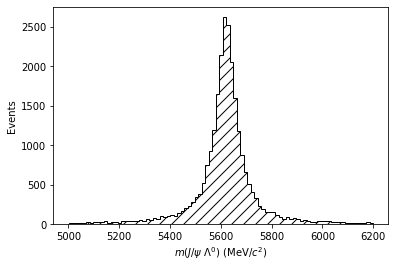

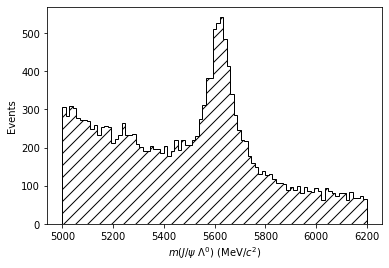

In [45]:
common_plot_params = {
    'bins': 87,
    'histtype': 'stepfilled',
    'facecolor': 'none',
    'edgecolor': 'black',
    'hatch': '//'
}

xlabel = "$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)"
ylabel = 'Events'

plt.hist(df_mc['DTF_FixJPsiLambda_Lb_M'], **common_plot_params)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

plt.hist(df_data['DTF_FixJPsiLambda_Lb_M'], **common_plot_params)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

# Proton helicity angle

In [47]:
df_test = df_mc.copy()

In [52]:
from lb2jpsil import helicity_angles, lorentz

In [53]:
prefix = 'DTF_FixJPsi_'

df = df_test

daughters = {
    f'{prefix}p' : 938.27208816,
    f'{prefix}pim' : 139.57018,
    }

suffix='IntermediateFrame'

In [60]:
daughters_p = {
    part_name : lorentz.four_vector_from_PXPYPZM(df[f'{part_name}_PX'], df[f'{part_name}_PY'], df[f'{part_name}_PZ'], part_mass)
    for part_name, part_mass in daughters.items()
}

In [63]:
daughters_p

{'DTF_FixJPsi_p': array([[  2527.50146484,   1047.94287109,    548.20251465, ...,
          -3465.34863281,  -2307.60083008,   1144.7331543 ],
        [   636.28405762,   2238.6940918 ,    695.22589111, ...,
          -1075.46728516,   -463.43356323,    670.57043457],
        [ 67836.328125  ,  72223.9296875 ,  47961.8828125 , ...,
         118623.828125  ,  73979.3515625 ,  65757.328125  ],
        [ 67892.86339092,  72272.30607751,  47979.22979314, ...,
         118683.01496586,  74022.73155378,  65777.4034242 ]]),
 'DTF_FixJPsi_pim': array([[  385.29425049,   245.03215027,    68.58628845, ...,
          -265.74536133,  -177.25007629,   256.91668701],
        [   95.79647064,   348.74258423,   250.07528687, ...,
          -171.9516449 ,    21.35926437,   284.86700439],
        [ 9422.16210938,  9896.49023438,  8895.80957031, ...,
         17884.60351562,  7506.46240234, 19393.0625    ],
        [ 9431.55578127,  9906.64736324,  8900.68230883, ...,
         17887.94867496,  7509.88213

In [65]:
mother_p = sum(daughters_p.values())

In [66]:
daughters_p_star = { part_name : lorentz.boost_from_mom(part_p, mother_p) for part_name, part_p in daughters_p.items() }

In [67]:
daughters_p_star

{'DTF_FixJPsi_p': array([[ -29.58758601,  -88.55262199,   27.9302571 , ..., -226.36975919,
          -53.85389339,   61.08380419],
        [  -6.39578886,  -35.60361107, -102.15236131, ...,    7.42249659,
          -62.47445768,  -68.10132872],
        [  12.53999465,   41.95742241,    1.41429197, ...,  120.26674321,
           72.13920779,  -74.49573164],
        [ 938.84954123,  944.00231357,  944.26732992, ...,  972.59127045,
          944.74556459,  945.74786552]]),
 'DTF_FixJPsi_pim': array([[  29.58758601,   88.55262199,  -27.9302571 , ...,  226.36975919,
           53.85389339,  -61.08380419],
        [   6.39578886,   35.60361107,  102.15236131, ...,   -7.42249659,
           62.47445768,   68.10132872],
        [ -12.53999465,  -41.95742241,   -1.41429197, ..., -120.26674321,
          -72.13920779,   74.49573164],
        [ 143.35480285,  174.21390632,  175.19454261, ...,  291.95782663,
          177.44126531,  182.77129578]])}